### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import numpy as np
from tqdm import tqdm
from scipy.misc import imread, imresize
import os

import torch.nn.functional as F

In [2]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [3]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [4]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [5]:
import torch
from torch.autograd import Variable

dummy_x = Variable(torch.randn(5, 3, 299, 299))
model(dummy_x)

tensor([[-1.1840,  0.9206,  1.8168,  ..., -2.0598, -0.5237,  1.3347],
        [-1.1026,  0.6759,  1.4888,  ..., -2.1479, -0.5383,  1.7821],
        [-0.9264,  0.9450,  1.9206,  ..., -1.9941, -0.5554,  1.5274],
        [-1.2266,  0.7650,  2.1303,  ..., -2.2588, -0.5456,  1.5845],
        [-0.9856,  1.0820,  1.6473,  ..., -2.2822, -0.3875,  1.8769]],
       grad_fn=<AddmmBackward>)

### Predict class probabilities

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


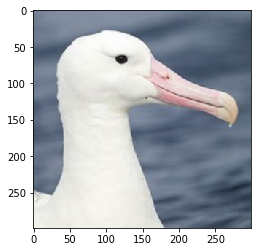

top-10 classes are: 
 [prob : class label]
0.9743 :	albatross
0.0031 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0004 :	collie
0.0003 :	drake
0.0003 :	hammerhead
0.0003 :	nipple
0.0003 :	Polaroid camera


In [7]:
import matplotlib.pyplot as plt
from scipy.misc import imresize
%matplotlib inline

img = imresize(plt.imread('sample_images/albatross.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2])))

probs = torch.nn.functional.softmax(model(img), dim=-1)

probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))



### Having fun with pre-trained nets

In [ ]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

In [ ]:
img = imresize(plt.imread('img.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2])))

probs = torch.nn.functional.softmax(model(img), dim=-1)

probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))



# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [7]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        #<YOUR CODE>
        return x
        
    
# redefine the last layer to be Identity
#<YOUR CODE>
embedding.fc = Identity()
assert embedding(img).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [11]:
#extract features from images


X = []
Y = []
embedding = embedding.cuda()
batch_size = 16 #<YOUR VALUE>
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = imresize(img, (299, 299)) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = Variable(torch.FloatTensor(imgs.transpose([0,3,1,2]))).cuda()
    
        # use your embedding model to produce feature vector        
        #features = <YOUR CODE>
        features = embedding(input_tensor).cpu().detach().numpy()
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]D:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [03:16<00:00, 127.17it/s]


In [12]:
import numpy as np

X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(24992, 2048) (24992,)


In [13]:
#<split data here or use cross-validation>
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.33, random_state=42)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [14]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [15]:
#<YOUR CODE>
classifier = RandomForestClassifier(n_estimators=200, n_jobs=5)
classifier.fit(X_train, y_train)
y_train_predict= classifier.predict(X_train)
train_roc = roc_auc_score(y_train, y_train_predict)

y_test_predict = classifier.predict(X_test)
test_roc = roc_auc_score(y_test, y_test_predict)

print('train roc: {}'.format(train_roc))
print('test roc: {}'.format(test_roc))

train roc: 1.0
test roc: 0.9825291903378188


# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

In [101]:
import torch.nn as nn
class New_model(torch.nn.Module):

    def __init__(self):
        super(New_model, self).__init__()
        self.linear1 = nn.Linear(2048,100)
        self.linear2 = nn.Linear(100,2)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
model.fc = New_model()

In [120]:
# фризим часть модели
for child in list(model.children())[:-1]:
    for param in child.parameters():
        param.requires_grad = False    

In [121]:
opt = torch.optim.Adamax(filter(lambda p: p.requires_grad, model.parameters()))
train_loss = []
val_accuracy = []

In [122]:
#Генерилка батчей
X = os.listdir('train')
Y = [int(fname.startswith("cat")) for fname in X]
X = np.array(X)
Y = np.array(Y)
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.33, random_state=42)


def iterate_minibatches(X, Y , batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], Y[ix]

In [123]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch.transpose([0,3,1,2]))).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [131]:
# Делаем из имен файлов тенсор 
def make_batch(X):
    
    imgs = np.zeros([X.shape[0], 299, 299, 3])
    index = 0
    for fname in X:
        img = imread(os.path.join("train", fname))
        img = imresize(img, (299, 299)) / 255.
        imgs[index] = img
        index+= 1
    return imgs

In [136]:
import time
num_epochs = 20
batch_size = 32
model = model.cuda()
for epoch in range(num_epochs):
    start_time = time.time()
    model.train = True
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        X_batch = make_batch(X_batch)
        
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        
    model.train = False
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, batch_size):
        X_batch = make_batch(X_batch)
        X_batch = Variable(torch.FloatTensor(X_batch.transpose([0,3,1,2]))).cuda()
        logits = model(X_batch).cpu()
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))
    
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_test) // batch_size :]) * 100))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


Epoch 1 of 20 took 197.467s
  training loss (in-iteration): 	0.016530
  validation accuracy: 			98.33 %
Epoch 2 of 20 took 185.951s
  training loss (in-iteration): 	0.014496
  validation accuracy: 			98.65 %
Epoch 3 of 20 took 189.041s
  training loss (in-iteration): 	0.013068
  validation accuracy: 			98.47 %
Epoch 4 of 20 took 183.525s
  training loss (in-iteration): 	0.010827
  validation accuracy: 			98.56 %
Epoch 5 of 20 took 175.679s
  training loss (in-iteration): 	0.010184
  validation accuracy: 			98.53 %
Epoch 6 of 20 took 176.070s
  training loss (in-iteration): 	0.007951
  validation accuracy: 			98.04 %
Epoch 7 of 20 took 175.525s
  training loss (in-iteration): 	0.006603
  validation accuracy: 			98.35 %
Epoch 8 of 20 took 176.170s
  training loss (in-iteration): 	0.006448
  validation accuracy: 			98.61 %
Epoch 9 of 20 took 175.428s
  training loss (in-iteration): 	0.003929
  validation accuracy: 			98.40 %
Epoch 10 of 20 took 175.698s
  training loss (in-iteration): 	0.

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [140]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [141]:
modulelist = list(model.children())

In [142]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])

def dd_helper(image, layer, iterations, lr):        
    
    input_var = Variable(preprocess(image).unsqueeze(0), requires_grad=True)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0,1)
    input_im.transpose_(1,2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [143]:
def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

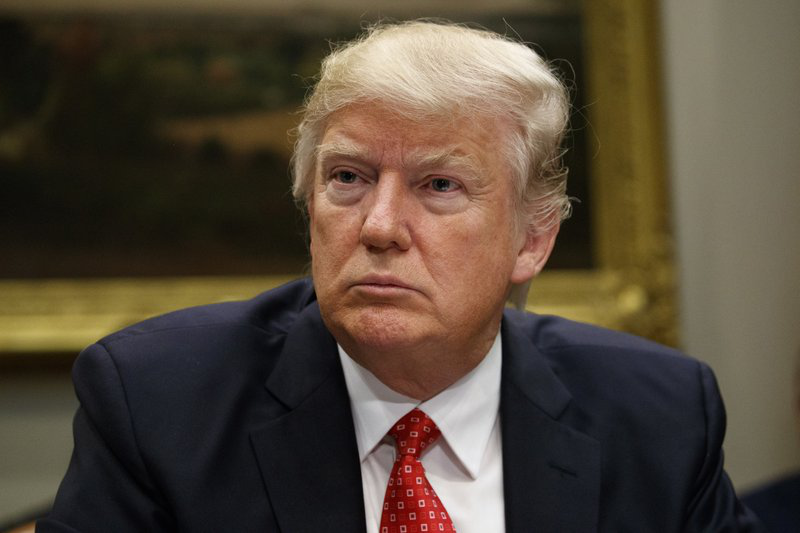

In [145]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [146]:
output = deep_dream_vgg(img, 5, 5, 0.3, 2, 20)

-------------- Recursive level:  0 --------------


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------
-------------- Recursive level:  2 --------------
-------------- Recursive level:  3 --------------
-------------- Recursive level:  4 --------------
-------------- Recursive level:  5 --------------


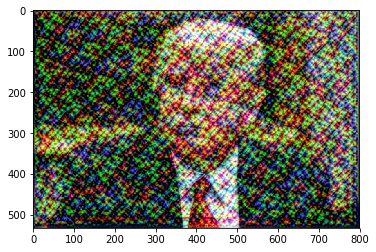

In [157]:
output = deep_dream_vgg(img, 5, 10, 0.3, 2, 5)

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------
-------------- Recursive level:  2 --------------
-------------- Recursive level:  3 --------------
-------------- Recursive level:  4 --------------
-------------- Recursive level:  5 --------------


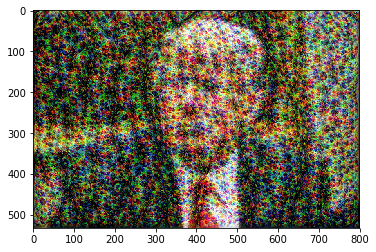

In [162]:
output = deep_dream_vgg(img, 12, 10, 0.3, 2, 5)

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------


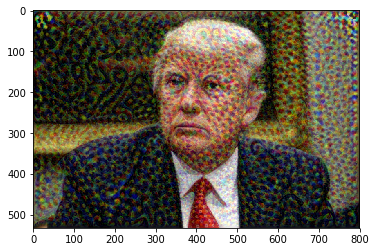

In [147]:
output = deep_dream_vgg(img, 12, 5, 0.2, 2, 1)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
#<YOUR CODE>

# one class probabiliti oprimization


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """Entry point for launching an IPython kernel.


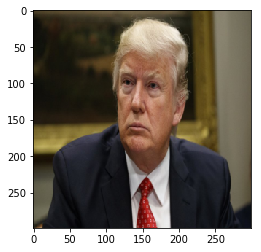

In [92]:
img = imresize(plt.imread('img.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

lr = 0.1
img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2])),requires_grad=True).cuda()
input_var = Variable(img, requires_grad=True).cuda()

template = Variable(torch.LongTensor([954])).reshape((1)).cuda()

model.zero_grad()
for i in range(250):
    out = input_var
    out = model(out)
    loss= F.cross_entropy(out, template)
    loss.backward()
    input_var.data = input_var.data - lr * input_var.grad.data

In [94]:
probs = torch.nn.functional.softmax(model(input_var), dim=-1)
probs = probs.cpu().data.numpy()
top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))

top-10 classes are: 
 [prob : class label]
0.9992 :	banana
0.0002 :	pineapple
0.0001 :	custard apple
0.0000 :	bubble
0.0000 :	peacock
0.0000 :	jackfruit
0.0000 :	Gila monster
0.0000 :	orange
0.0000 :	lorikeet


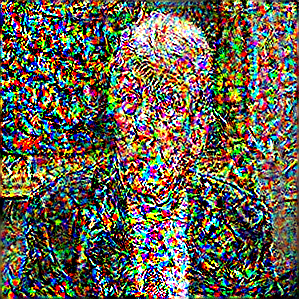

In [95]:
from PIL import Image
input_im = input_var.cpu().data.squeeze()
input_im.transpose_(0,1)
input_im.transpose_(1,2)
input_im = np.clip(input_im, 0, 1)
im = Image.fromarray(np.uint8(input_im * 255))
im